In [1]:
#!/usr/bin/env python3
"""
Ternary Decision System Diagnostic Analysis
============================================
Analyzes the performance of the new UP/DOWN/NO_DECISION system
"""
import sys
import pandas as pd
import numpy as np
from pathlib import Path

sys.path.insert(0, str(Path.cwd()))

from core.prediction_database import PredictionDatabase

def analyze_system():
    print("="*80)
    print("TERNARY DECISION SYSTEM DIAGNOSTIC")
    print("="*80)
    
    db = PredictionDatabase()
    
    # Get all predictions
    all_preds = db.get_predictions()
    print(f"\n📊 TOTAL PREDICTIONS: {len(all_preds)}")
    
    # Breakdown by direction
    up_count = len(all_preds[all_preds['direction_prediction'] == 'UP'])
    down_count = len(all_preds[all_preds['direction_prediction'] == 'DOWN'])
    no_decision_count = len(all_preds[all_preds['direction_prediction'] == 'NO_DECISION'])
    
    print(f"\n📈 PREDICTION BREAKDOWN:")
    print(f"   UP:          {up_count:4d} ({up_count/len(all_preds)*100:5.1f}%)")
    print(f"   DOWN:        {down_count:4d} ({down_count/len(all_preds)*100:5.1f}%)")
    print(f"   NO_DECISION: {no_decision_count:4d} ({no_decision_count/len(all_preds)*100:5.1f}%)")
    
    # Get predictions with actuals
    with_actuals = db.get_predictions(with_actuals=True)
    print(f"\n✅ PREDICTIONS WITH ACTUALS: {len(with_actuals)}")
    
    if len(with_actuals) == 0:
        print("\n⚠️  No predictions with actuals yet - run system for a few days")
        return
    
    # Separate decisions from no-decisions
    decisions = with_actuals[with_actuals['direction_prediction'].isin(['UP', 'DOWN'])].copy()
    no_decisions = with_actuals[with_actuals['direction_prediction'] == 'NO_DECISION'].copy()
    
    print(f"\n📊 WITH ACTUALS BREAKDOWN:")
    print(f"   Made decision:    {len(decisions):4d} ({len(decisions)/len(with_actuals)*100:5.1f}%)")
    print(f"   NO_DECISION:      {len(no_decisions):4d} ({len(no_decisions)/len(with_actuals)*100:5.1f}%)")
    
    if len(decisions) == 0:
        print("\n⚠️  No directional predictions with actuals yet")
        return
    
    # Analyze decisions
    print("\n" + "="*80)
    print("DIRECTIONAL SIGNAL PERFORMANCE (UP/DOWN only)")
    print("="*80)
    
    up_preds = decisions[decisions['direction_prediction'] == 'UP'].copy()
    down_preds = decisions[decisions['direction_prediction'] == 'DOWN'].copy()
    
    print(f"\n📈 UP SIGNALS: {len(up_preds)}")
    if len(up_preds) > 0:
        up_acc = up_preds['direction_correct'].mean()
        up_avg_conf = up_preds['direction_confidence'].mean()
        up_avg_mag = up_preds['magnitude_forecast'].mean()
        print(f"   Accuracy:    {up_acc:.1%}")
        print(f"   Avg Confidence: {up_avg_conf:.1%}")
        print(f"   Avg Magnitude:  {up_avg_mag:+.2f}%")
    
    print(f"\n📉 DOWN SIGNALS: {len(down_preds)}")
    if len(down_preds) > 0:
        down_acc = down_preds['direction_correct'].mean()
        down_avg_conf = down_preds['direction_confidence'].mean()
        down_avg_mag = down_preds['magnitude_forecast'].mean()
        print(f"   Accuracy:    {down_acc:.1%}")
        print(f"   Avg Confidence: {down_avg_conf:.1%}")
        print(f"   Avg Magnitude:  {down_avg_mag:+.2f}%")
    
    print(f"\n✅ OVERALL DIRECTIONAL:")
    overall_acc = decisions['direction_correct'].mean()
    print(f"   Accuracy: {overall_acc:.1%}")
    print(f"   MAE: {decisions['magnitude_error'].mean():.2f}%")
    
    # Balance check
    print("\n" + "="*80)
    print("BALANCE CHECK")
    print("="*80)
    
    if len(up_preds) > 0 and len(down_preds) > 0:
        balance_ratio = len(up_preds) / len(down_preds)
        acc_diff = abs(up_acc - down_acc)
        
        print(f"\n📊 Signal Balance:")
        print(f"   UP/DOWN Ratio: {balance_ratio:.2f} (ideal: 0.6-1.5)")
        
        if balance_ratio < 0.4:
            print("   ⚠️  TOO FEW UP signals - system may be biased")
        elif balance_ratio > 2.0:
            print("   ⚠️  TOO MANY UP signals - system may be biased")
        else:
            print("   ✅ Good balance")
        
        print(f"\n📊 Accuracy Balance:")
        print(f"   UP vs DOWN diff: {acc_diff:.1%} (ideal: <10%)")
        
        if acc_diff > 0.15:
            print("   ⚠️  LARGE accuracy imbalance - check for bias")
        elif acc_diff > 0.10:
            print("   ⚠️  Moderate imbalance - monitor closely")
        else:
            print("   ✅ Good balance")
    
    # Confidence analysis
    print("\n" + "="*80)
    print("CONFIDENCE DISTRIBUTION")
    print("="*80)
    
    bins = [0.70, 0.75, 0.80, 0.85, 0.90, 1.0]
    for i in range(len(bins)-1):
        in_bin = decisions[(decisions['direction_confidence'] >= bins[i]) & 
                          (decisions['direction_confidence'] < bins[i+1])]
        if len(in_bin) > 0:
            acc = in_bin['direction_correct'].mean()
            up_count_bin = len(in_bin[in_bin['direction_prediction'] == 'UP'])
            down_count_bin = len(in_bin[in_bin['direction_prediction'] == 'DOWN'])
            print(f"\n{bins[i]:.0%}-{bins[i+1]:.0%}: n={len(in_bin):3d} | acc={acc:.1%} | up/dn={up_count_bin}/{down_count_bin}")
    
    # NO_DECISION analysis
    print("\n" + "="*80)
    print("NO_DECISION ANALYSIS")
    print("="*80)
    
    if len(no_decisions) > 0:
        print(f"\n📊 NO_DECISION Predictions: {len(no_decisions)}")
        print(f"   Rate: {len(no_decisions)/len(with_actuals)*100:.1f}%")
        
        # What would accuracy have been if we forced these?
        no_dec_up_would_be_right = (no_decisions['actual_direction'] == 1).sum()
        no_dec_down_would_be_right = (no_decisions['actual_direction'] == 0).sum()
        
        # Assume we'd predict based on prob_up > 0.5
        would_predict_up = (no_decisions['prob_up'] > 0.5).sum()
        would_predict_down = len(no_decisions) - would_predict_up
        
        print(f"\n   If we had forced predictions:")
        print(f"   - Would predict UP:   {would_predict_up}")
        print(f"   - Would predict DOWN: {would_predict_down}")
        print(f"   - Actual UP outcomes: {no_dec_up_would_be_right}")
        print(f"   - Actual DOWN outcomes: {no_dec_down_would_be_right}")
        
        # Hypothetical accuracy
        hypothetical_correct = 0
        for idx, row in no_decisions.iterrows():
            pred = 1 if row['prob_up'] > 0.5 else 0
            if pred == row['actual_direction']:
                hypothetical_correct += 1
        
        hyp_acc = hypothetical_correct / len(no_decisions)
        print(f"   - Hypothetical accuracy: {hyp_acc:.1%}")
        print(f"\n   ✅ By saying NO_DECISION, we avoided {len(no_decisions)} predictions")
        print(f"   that would have been only {hyp_acc:.1%} accurate")
    
    # Recommendation
    print("\n" + "="*80)
    print("SYSTEM HEALTH")
    print("="*80)
    
    issues = []
    
    if len(decisions) < 100:
        issues.append("⚠️  Need more data (< 100 decisions with actuals)")
    
    if len(up_preds) > 0 and len(down_preds) > 0:
        if abs(up_acc - down_acc) > 0.15:
            issues.append("⚠️  Large accuracy imbalance between UP and DOWN")
        if balance_ratio < 0.4 or balance_ratio > 2.0:
            issues.append("⚠️  Signal volume imbalance")
    
    if overall_acc < 0.70:
        issues.append("⚠️  Overall accuracy below 70%")
    
    no_dec_rate = len(no_decisions) / len(with_actuals)
    if no_dec_rate > 0.60:
        issues.append("⚠️  Too many NO_DECISION (>60%) - threshold may be too high")
    elif no_dec_rate < 0.20:
        issues.append("⚠️  Too few NO_DECISION (<20%) - system may be overconfident")
    
    if len(issues) == 0:
        print("\n✅ SYSTEM LOOKS HEALTHY!")
        print(f"   - Accuracy: {overall_acc:.1%}")
        print(f"   - Balance: Good")
        print(f"   - NO_DECISION rate: {no_dec_rate:.1%} (good)")
    else:
        print("\n⚠️  ISSUES DETECTED:")
        for issue in issues:
            print(f"   {issue}")
    
    # Recommendations
    print("\n" + "="*80)
    print("RECOMMENDATIONS")
    print("="*80)
    
    if no_dec_rate > 0.55:
        print("\n🔧 Consider lowering decision_threshold in config.py:")
        print("   Current: 0.70 → Try: 0.65")
        print("   This will make more predictions (fewer NO_DECISION)")
    elif no_dec_rate < 0.25:
        print("\n🔧 Consider raising decision_threshold in config.py:")
        print("   Current: 0.70 → Try: 0.75")
        print("   This will be more selective (more NO_DECISION)")
    else:
        print("\n✅ Current decision_threshold (0.70) seems appropriate")
    
    if len(decisions) > 100 and abs(up_acc - down_acc) > 0.10:
        print("\n🔧 Accuracy imbalance detected - consider:")
        print("   1. Run unified_tuner_upgraded.py --frozen 200")
        print("   2. This will re-optimize for balanced performance")
    
    print("\n" + "="*80)

if __name__ == "__main__":
    try:
        analyze_system()
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()

TERNARY DECISION SYSTEM DIAGNOSTIC

📊 TOTAL PREDICTIONS: 496

📈 PREDICTION BREAKDOWN:
   UP:           130 ( 26.2%)
   DOWN:         191 ( 38.5%)
   NO_DECISION:  175 ( 35.3%)

✅ PREDICTIONS WITH ACTUALS: 315

📊 WITH ACTUALS BREAKDOWN:
   Made decision:     315 (100.0%)
   NO_DECISION:         0 (  0.0%)

DIRECTIONAL SIGNAL PERFORMANCE (UP/DOWN only)

📈 UP SIGNALS: 126
   Accuracy:    81.7%
   Avg Confidence: 74.9%
   Avg Magnitude:  +12.12%

📉 DOWN SIGNALS: 189
   Accuracy:    72.0%
   Avg Confidence: 72.0%
   Avg Magnitude:  -11.91%

✅ OVERALL DIRECTIONAL:
   Accuracy: 75.9%
   MAE: 14.39%

BALANCE CHECK

📊 Signal Balance:
   UP/DOWN Ratio: 0.67 (ideal: 0.6-1.5)
   ✅ Good balance

📊 Accuracy Balance:
   UP vs DOWN diff: 9.8% (ideal: <10%)
   ✅ Good balance

CONFIDENCE DISTRIBUTION

70%-75%: n=218 | acc=73.4% | up/dn=70/148

75%-80%: n= 56 | acc=87.5% | up/dn=56/0

NO_DECISION ANALYSIS

SYSTEM HEALTH

⚠️  ISSUES DETECTED:
   ⚠️  Too few NO_DECISION (<20%) - system may be overconfident

VIX FORECASTING SYSTEM DIAGNOSTIC

1. Loading data...

🏗️  Building 20y feature set | Temporal Safety: ON
Mode: HISTORICAL
Date Ranges: Warmup Start -> Warmup End (usable period) -> Training End Date: 2004-09-11 → 2005-12-05 → 2025-11-30
   → Building VX futures features from cached contracts...
   → Building VX futures from cache
   ✓ Loaded 6 contracts
   ✓ Loaded 6 continuous contracts
   → Generating legacy spread & ratio features...
   → Generating term structure features...
   → Generating positioning features...
   → Generating roll characteristics...
   → Generating regime indicators...
   ✓ Generated 35 VX features | Coverage: 5339 days
   → Commodity/currency features: 104 features | 94.4% coverage
⚠️  Replaced sparse Yahoo 2Y (20.2% coverage) with FRED DGS2


INFO:core.xgboost_trainer_v3:Using directional ensemble config (up/down specific parameters)
INFO:core.xgboost_trainer_v3:✅ Loaded 4 models: 35 exp, 42 comp, 30 up, 31 down features
INFO:core.xgboost_trainer_v3:✅ Loaded optimal thresholds: UP=inf, DOWN=0.501



✅ Complete: 509 features | 5339 rows
   Date range: 2004-09-13 → 2025-11-28

   Val: 501 samples
   Test: 480 samples

2. Loading trained models...

3. BASE CLASSIFIER ANALYSIS

📊 UP CLASSIFIER (Validation Set)
--------------------------------------------------------------------------------
Thresh   Acc      Prec     Rec      F1      
--------------------------------------------------------------------------------
0.300    43.1%    43.1%    100.0%   60.3%   
0.338    45.5%    44.1%    99.1%    61.1%   
0.400    48.9%    43.7%    64.4%    52.1%   
0.500    59.5%    57.3%    23.6%    33.4%   
0.600    59.3%    87.5%    6.5%     12.1%   
0.700    56.9%    0.0%     0.0%     0.0%    

📊 DOWN CLASSIFIER (Validation Set)
--------------------------------------------------------------------------------
Thresh   Acc      Prec     Rec      F1      
--------------------------------------------------------------------------------
0.300    56.9%    56.9%    100.0%   72.5%   
0.338    56.9%    56.9%

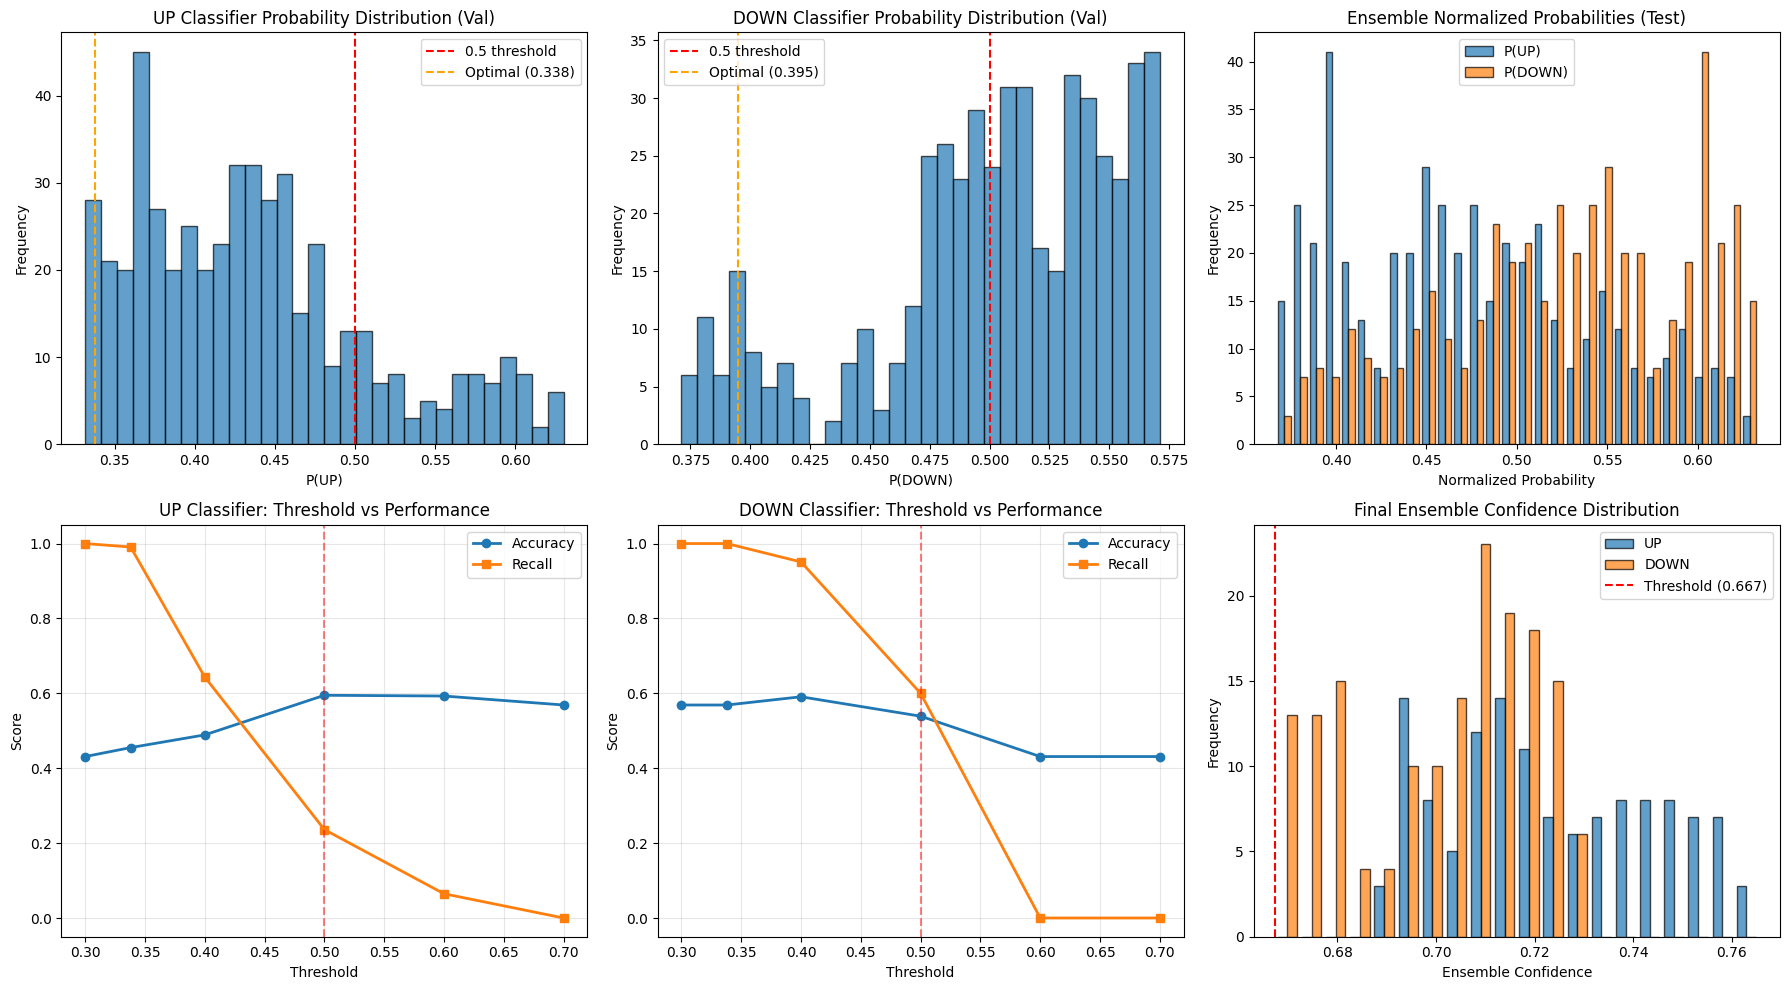

In [3]:
# VIX Forecasting System Diagnostic
# Run this in /src directory in Jupyter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json

# Load models and data
from core.xgboost_trainer_v3 import AsymmetricVIXForecaster
from config import TRAINING_YEARS, get_last_complete_month_end, TRAIN_END_DATE, VAL_END_DATE
from core.data_fetcher import UnifiedDataFetcher
from features.feature_engineer import FeatureEngineer
from core.target_calculator import TargetCalculator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("="*80)
print("VIX FORECASTING SYSTEM DIAGNOSTIC")
print("="*80)

# Load data
print("\n1. Loading data...")
training_end = get_last_complete_month_end()
fetcher = UnifiedDataFetcher()
engineer = FeatureEngineer(fetcher)
result = engineer.build_complete_features(years=TRAINING_YEARS, end_date=training_end)

df = result["features"].copy()
df["vix"] = result["vix"]

calculator = TargetCalculator()
df = calculator.calculate_all_targets(df, vix_col='vix')

# Filter quality
from config import QUALITY_FILTER_CONFIG
if 'feature_quality' in df.columns:
    threshold = QUALITY_FILTER_CONFIG['min_threshold']
    df = df[df['feature_quality'] >= threshold].copy()

# Split data
train_end = pd.Timestamp(TRAIN_END_DATE)
val_end = pd.Timestamp(VAL_END_DATE)
val_df = df[(df.index > train_end) & (df.index <= val_end)].copy()
test_df = df[df.index > val_end].copy()

print(f"   Val: {len(val_df)} samples")
print(f"   Test: {len(test_df)} samples")

# Load models
print("\n2. Loading trained models...")
forecaster = AsymmetricVIXForecaster(use_ensemble=True)
forecaster.load("models")

# Test classifiers at different thresholds
print("\n3. BASE CLASSIFIER ANALYSIS")
print("="*80)

def evaluate_at_threshold(model, X, y_true, threshold, name):
    """Evaluate classifier at specific threshold"""
    proba = model.predict_proba(X)[:, 1]
    y_pred = (proba >= threshold).astype(int)
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    return {
        'name': name,
        'threshold': threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'avg_proba': proba.mean(),
        'proba_std': proba.std(),
        'proba_min': proba.min(),
        'proba_max': proba.max()
    }

# UP Classifier
X_up_val = val_df[forecaster.up_features]
y_up_val = val_df['target_direction']
X_up_test = test_df[forecaster.up_features]
y_up_test = test_df['target_direction']

# DOWN Classifier  
X_down_val = val_df[forecaster.down_features]
y_down_val = 1 - val_df['target_direction']
X_down_test = test_df[forecaster.down_features]
y_down_test = 1 - test_df['target_direction']

# Test multiple thresholds
thresholds = [0.3, 0.338, 0.4, 0.5, 0.6, 0.7]

print("\n📊 UP CLASSIFIER (Validation Set)")
print("-" * 80)
print(f"{'Thresh':<8} {'Acc':<8} {'Prec':<8} {'Rec':<8} {'F1':<8}")
print("-" * 80)
up_results = []
for thresh in thresholds:
    result = evaluate_at_threshold(forecaster.up_classifier, X_up_val, y_up_val, thresh, 'UP')
    up_results.append(result)
    print(f"{thresh:<8.3f} {result['accuracy']:<8.1%} {result['precision']:<8.1%} {result['recall']:<8.1%} {result['f1']:<8.1%}")

print("\n📊 DOWN CLASSIFIER (Validation Set)")
print("-" * 80)
print(f"{'Thresh':<8} {'Acc':<8} {'Prec':<8} {'Rec':<8} {'F1':<8}")
print("-" * 80)
down_results = []
for thresh in thresholds:
    result = evaluate_at_threshold(forecaster.down_classifier, X_down_val, y_down_val, thresh, 'DOWN')
    down_results.append(result)
    print(f"{thresh:<8.3f} {result['accuracy']:<8.1%} {result['precision']:<8.1%} {result['recall']:<8.1%} {result['f1']:<8.1%}")

# Probability distributions
print("\n4. PROBABILITY DISTRIBUTION ANALYSIS")
print("="*80)

up_proba_val = forecaster.up_classifier.predict_proba(X_up_val)[:, 1]
down_proba_val = forecaster.down_classifier.predict_proba(X_down_val)[:, 1]

print(f"\nUP Classifier Probabilities (Val):")
print(f"  Mean: {up_proba_val.mean():.3f}")
print(f"  Median: {np.median(up_proba_val):.3f}")
print(f"  Std: {up_proba_val.std():.3f}")
print(f"  Range: [{up_proba_val.min():.3f}, {up_proba_val.max():.3f}]")
print(f"  % above 0.5: {(up_proba_val > 0.5).mean():.1%}")
print(f"  % above 0.7: {(up_proba_val > 0.7).mean():.1%}")

print(f"\nDOWN Classifier Probabilities (Val):")
print(f"  Mean: {down_proba_val.mean():.3f}")
print(f"  Median: {np.median(down_proba_val):.3f}")
print(f"  Std: {down_proba_val.std():.3f}")
print(f"  Range: [{down_proba_val.min():.3f}, {down_proba_val.max():.3f}]")
print(f"  % above 0.5: {(down_proba_val > 0.5).mean():.1%}")
print(f"  % above 0.7: {(down_proba_val > 0.7).mean():.1%}")

# Ensemble behavior analysis
print("\n5. ENSEMBLE BEHAVIOR ANALYSIS (Test Set)")
print("="*80)

ensemble_predictions = []
for idx in test_df.index:
    if pd.isna(test_df.loc[idx, 'target_direction']):
        continue
    
    obs = test_df.loc[idx]
    X = pd.DataFrame(index=[0])
    
    for col in forecaster.expansion_features:
        X[col] = [obs[col]]
    for col in forecaster.compression_features:
        if col not in X.columns:
            X[col] = [obs[col]]
    for col in forecaster.up_features:
        if col not in X.columns:
            X[col] = [obs[col]]
    for col in forecaster.down_features:
        if col not in X.columns:
            X[col] = [obs[col]]
    
    X = X.fillna(0)
    current_vix = float(obs["vix"])
    
    pred = forecaster.predict(X, current_vix)
    
    ensemble_predictions.append({
        'p_up': pred['p_up'],
        'p_down': pred['p_down'],
        'direction': pred['direction'],
        'confidence': pred['direction_confidence'],
        'actual': 'UP' if int(obs['target_direction']) == 1 else 'DOWN'
    })

pred_df = pd.DataFrame(ensemble_predictions)

print(f"\nNormalized Probability Distribution:")
print(f"  P(UP) - Mean: {pred_df['p_up'].mean():.3f}, Median: {pred_df['p_up'].median():.3f}")
print(f"  P(DOWN) - Mean: {pred_df['p_down'].mean():.3f}, Median: {pred_df['p_down'].median():.3f}")

print(f"\nDecision Breakdown:")
decisions_only = pred_df[pred_df['direction'] != 'NO_DECISION']
print(f"  Total: {len(pred_df)}")
print(f"  Decisions: {len(decisions_only)} ({len(decisions_only)/len(pred_df):.1%})")
print(f"  NO_DECISION: {len(pred_df) - len(decisions_only)} ({(len(pred_df)-len(decisions_only))/len(pred_df):.1%})")

if len(decisions_only) > 0:
    up_dec = decisions_only[decisions_only['direction'] == 'UP']
    down_dec = decisions_only[decisions_only['direction'] == 'DOWN']
    
    print(f"\nSignal Distribution:")
    print(f"  UP: {len(up_dec)} ({len(up_dec)/len(decisions_only):.1%})")
    print(f"  DOWN: {len(down_dec)} ({len(down_dec)/len(decisions_only):.1%})")
    
    print(f"\nAccuracy:")
    up_dec['correct'] = up_dec['direction'] == up_dec['actual']
    down_dec['correct'] = down_dec['direction'] == down_dec['actual']
    print(f"  UP: {up_dec['correct'].mean():.1%}")
    print(f"  DOWN: {down_dec['correct'].mean():.1%}")

# Visualizations
print("\n6. Generating visualizations...")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# UP classifier probability histogram
axes[0, 0].hist(up_proba_val, bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0.5, color='red', linestyle='--', label='0.5 threshold')
axes[0, 0].axvline(0.338, color='orange', linestyle='--', label='Optimal (0.338)')
axes[0, 0].set_xlabel('P(UP)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('UP Classifier Probability Distribution (Val)')
axes[0, 0].legend()

# DOWN classifier probability histogram
axes[0, 1].hist(down_proba_val, bins=30, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(0.5, color='red', linestyle='--', label='0.5 threshold')
axes[0, 1].axvline(0.395, color='orange', linestyle='--', label='Optimal (0.395)')
axes[0, 1].set_xlabel('P(DOWN)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('DOWN Classifier Probability Distribution (Val)')
axes[0, 1].legend()

# Normalized ensemble probabilities
axes[0, 2].hist([pred_df['p_up'], pred_df['p_down']], bins=30, alpha=0.7, 
                label=['P(UP)', 'P(DOWN)'], edgecolor='black')
axes[0, 2].set_xlabel('Normalized Probability')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Ensemble Normalized Probabilities (Test)')
axes[0, 2].legend()

# Threshold vs Accuracy (UP)
thresh_vals = [r['threshold'] for r in up_results]
acc_vals = [r['accuracy'] for r in up_results]
rec_vals = [r['recall'] for r in up_results]
axes[1, 0].plot(thresh_vals, acc_vals, 'o-', label='Accuracy', linewidth=2)
axes[1, 0].plot(thresh_vals, rec_vals, 's-', label='Recall', linewidth=2)
axes[1, 0].axvline(0.5, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('UP Classifier: Threshold vs Performance')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Threshold vs Accuracy (DOWN)
thresh_vals = [r['threshold'] for r in down_results]
acc_vals = [r['accuracy'] for r in down_results]
rec_vals = [r['recall'] for r in down_results]
axes[1, 1].plot(thresh_vals, acc_vals, 'o-', label='Accuracy', linewidth=2)
axes[1, 1].plot(thresh_vals, rec_vals, 's-', label='Recall', linewidth=2)
axes[1, 1].axvline(0.5, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('DOWN Classifier: Threshold vs Performance')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Confidence distribution
if len(decisions_only) > 0:
    axes[1, 2].hist([up_dec['confidence'], down_dec['confidence']], 
                    bins=20, alpha=0.7, label=['UP', 'DOWN'], edgecolor='black')
    axes[1, 2].axvline(forecaster.decision_threshold, color='red', linestyle='--', 
                       label=f'Threshold ({forecaster.decision_threshold:.3f})')
    axes[1, 2].set_xlabel('Ensemble Confidence')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Final Ensemble Confidence Distribution')
    axes[1, 2].legend()

plt.tight_layout()
plt.savefig('diagnostic_analysis.png', dpi=150, bbox_inches='tight')
print("   Saved: diagnostic_analysis.png")

print("\n" + "="*80)
print("DIAGNOSIS COMPLETE")
print("="*80)


TERNARY TRAINING DIAGNOSTIC SUITE
Analyzing: Should ternary decision logic be incorporated into model training?

Loading models and configuration...
Loading test data...


INFO:train_probabilistic_models:📅 Training through: 2025-11-30



🏗️  Building 20y feature set | Temporal Safety: ON
Mode: HISTORICAL
Date Ranges: Warmup Start -> Warmup End (usable period) -> Training End Date: 2004-09-11 → 2005-12-05 → 2025-11-30
   → Building VX futures features from cached contracts...
   → Building VX futures from cache
   ✓ Loaded 6 contracts
   ✓ Loaded 6 continuous contracts
   → Generating legacy spread & ratio features...
   → Generating term structure features...
   → Generating positioning features...
   → Generating roll characteristics...
   → Generating regime indicators...
   ✓ Generated 35 VX features | Coverage: 5339 days
   → Commodity/currency features: 104 features | 94.4% coverage
⚠️  Replaced sparse Yahoo 2Y (20.2% coverage) with FRED DGS2


INFO:train_probabilistic_models:  Cohort distribution:
INFO:train_probabilistic_models:  fomc_period: 2938
INFO:train_probabilistic_models:  mid_cycle: 1375
INFO:train_probabilistic_models:  opex_week: 870
INFO:train_probabilistic_models:  earnings_heavy: 156
INFO:train_probabilistic_models:  Data preparation complete




✅ Complete: 509 features | 5339 rows
   Date range: 2004-09-13 → 2025-11-28

Test set: 480 samples from 2024-01-02 to 2025-11-28
Calculating targets for test set...
  Targets calculated: 480 valid samples
  UP: 229 (47.7%)
  DOWN: 251

Analyzing predictions sample-by-sample...

DIAGNOSTIC 1: CONFIDENCE DISTRIBUTION ANALYSIS
✓ Saved: diagnostic_1_confidence_distribution.png

SUMMARY STATISTICS:
Current threshold: 68.4%

ALL predictions:
  Below threshold: 166 samples, accuracy: 53.6%
  Above threshold: 314 samples, accuracy: 71.0%

UP predictions:
  Below threshold: 0 samples, accuracy: nan%
  Above threshold: 125 samples, accuracy: 74.4%

DOWN predictions:
  Below threshold: 166 samples, accuracy: 53.6%
  Above threshold: 189 samples, accuracy: 68.8%

DIAGNOSTIC 2: RAW CLASSIFIER PROBABILITY ANALYSIS
✓ Saved: diagnostic_2_classifier_calibration.png

CLASSIFIER PERFORMANCE AT DIFFERENT THRESHOLDS:

UP Classifier:
Threshold    Precision    Recall       F1           Count       
--------

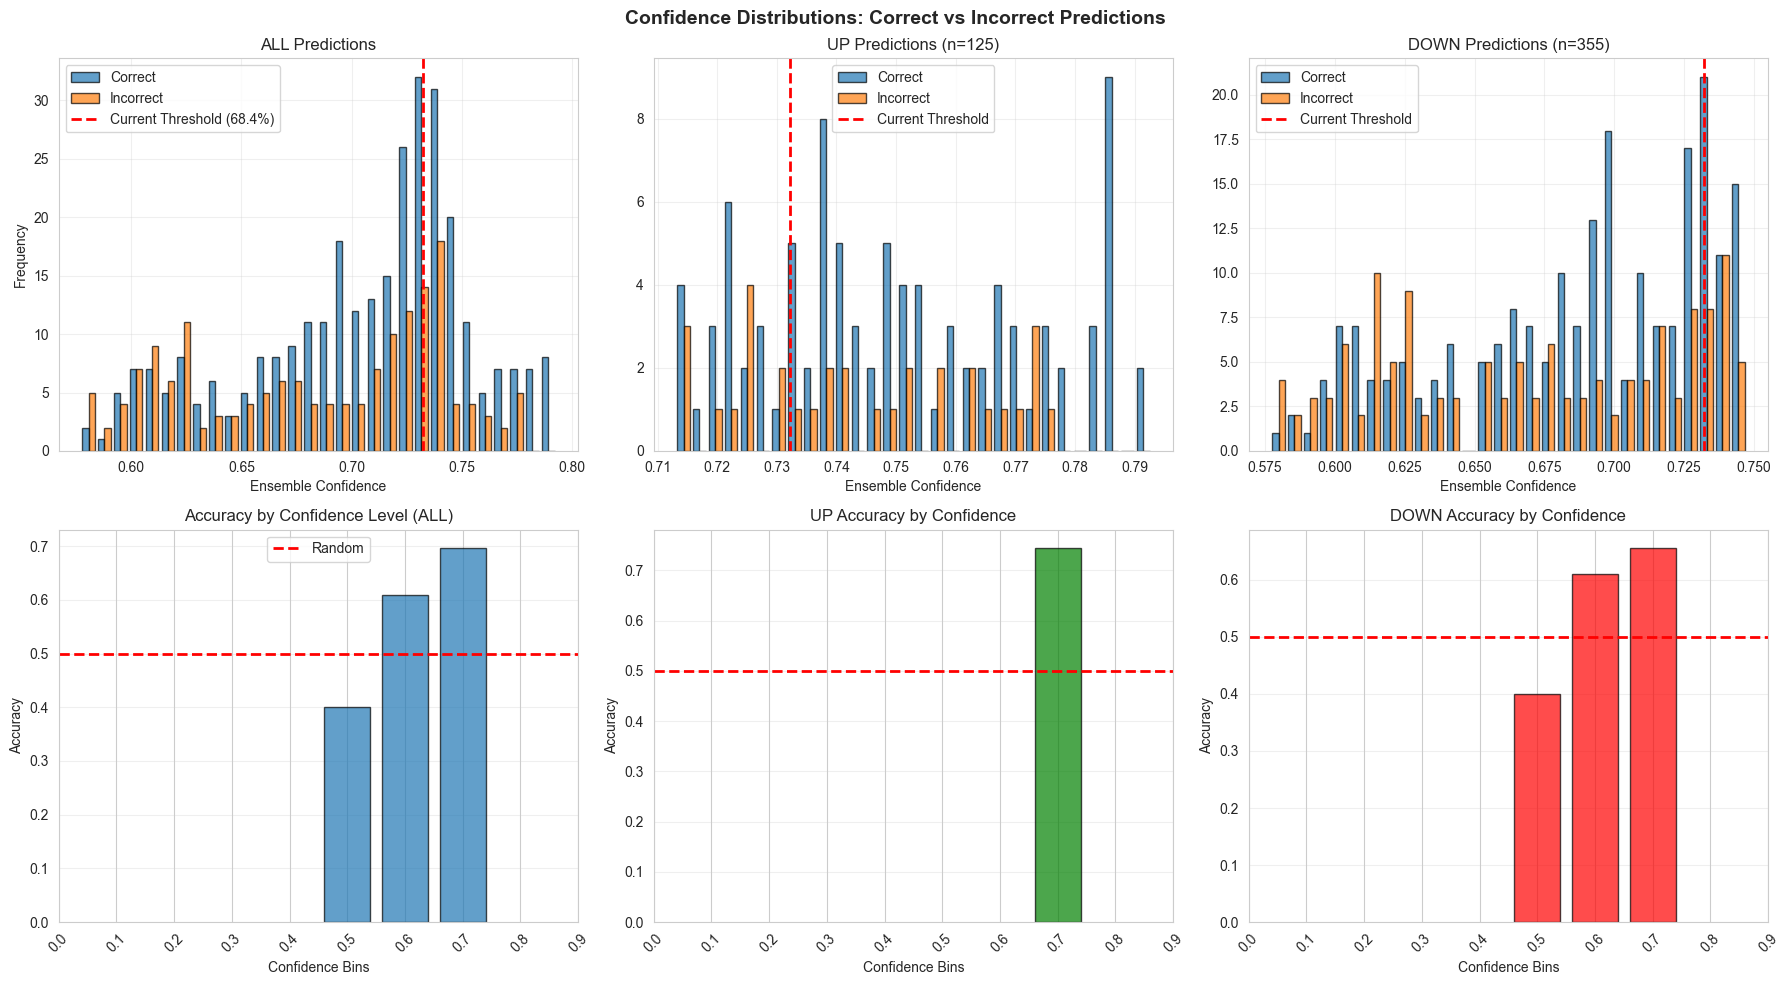

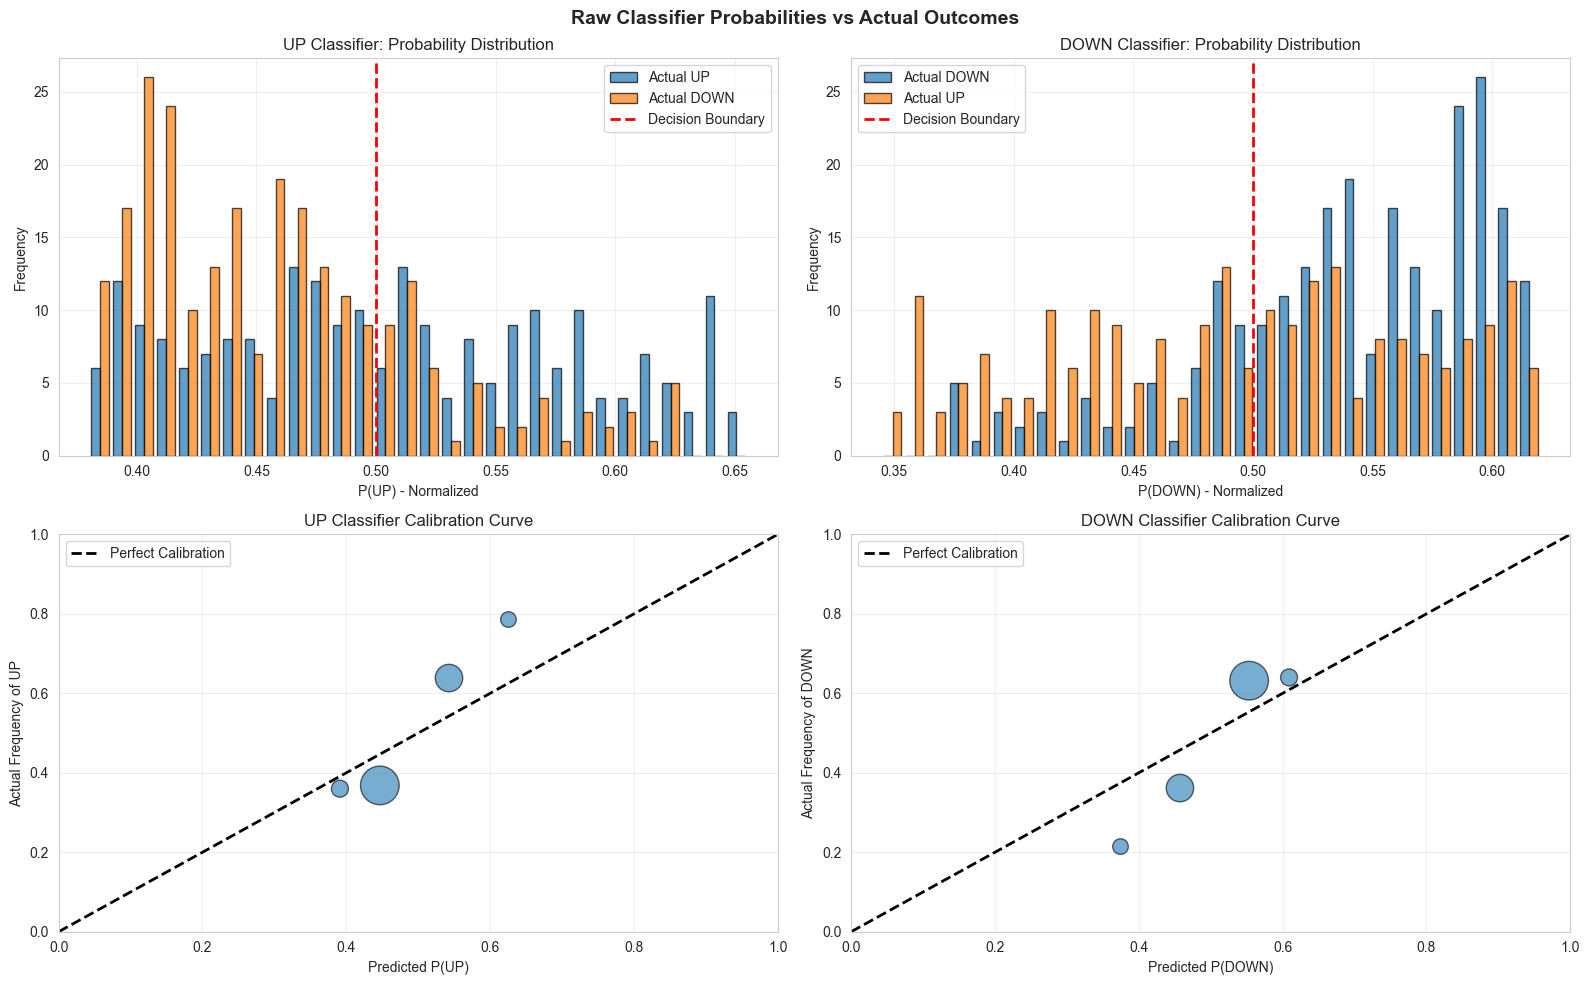

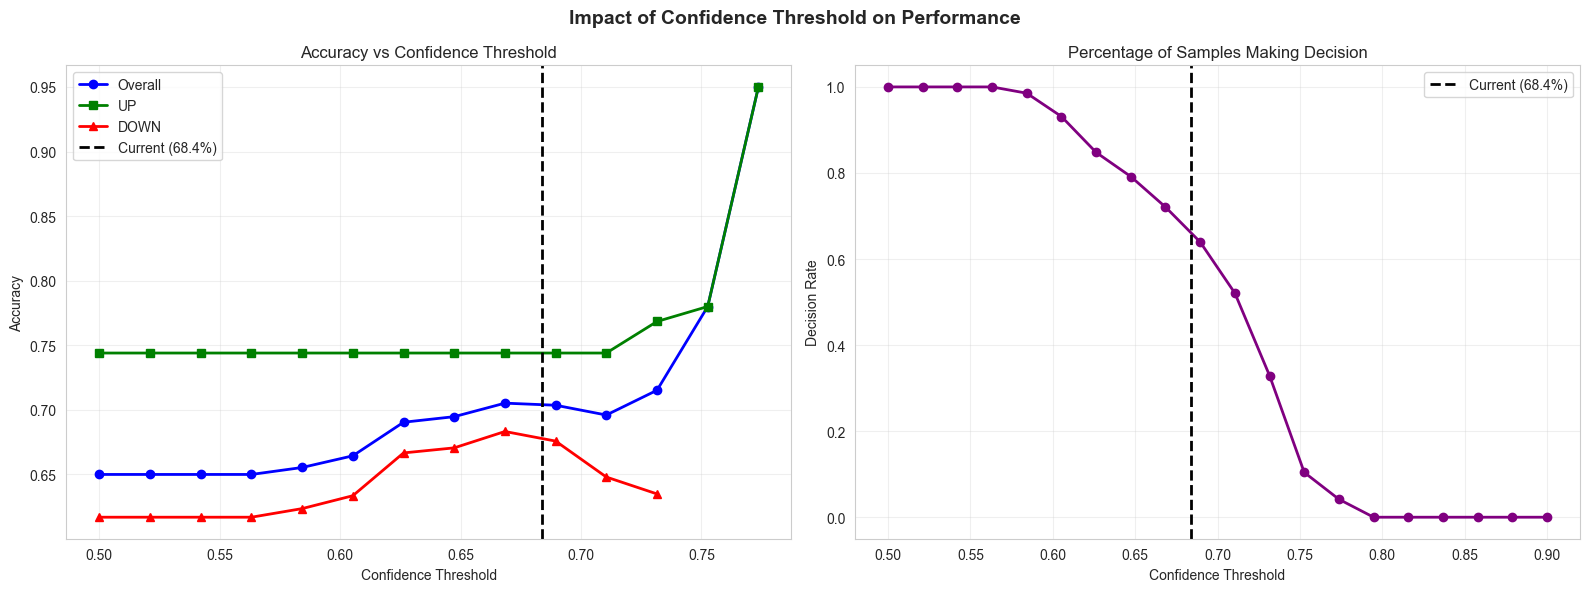

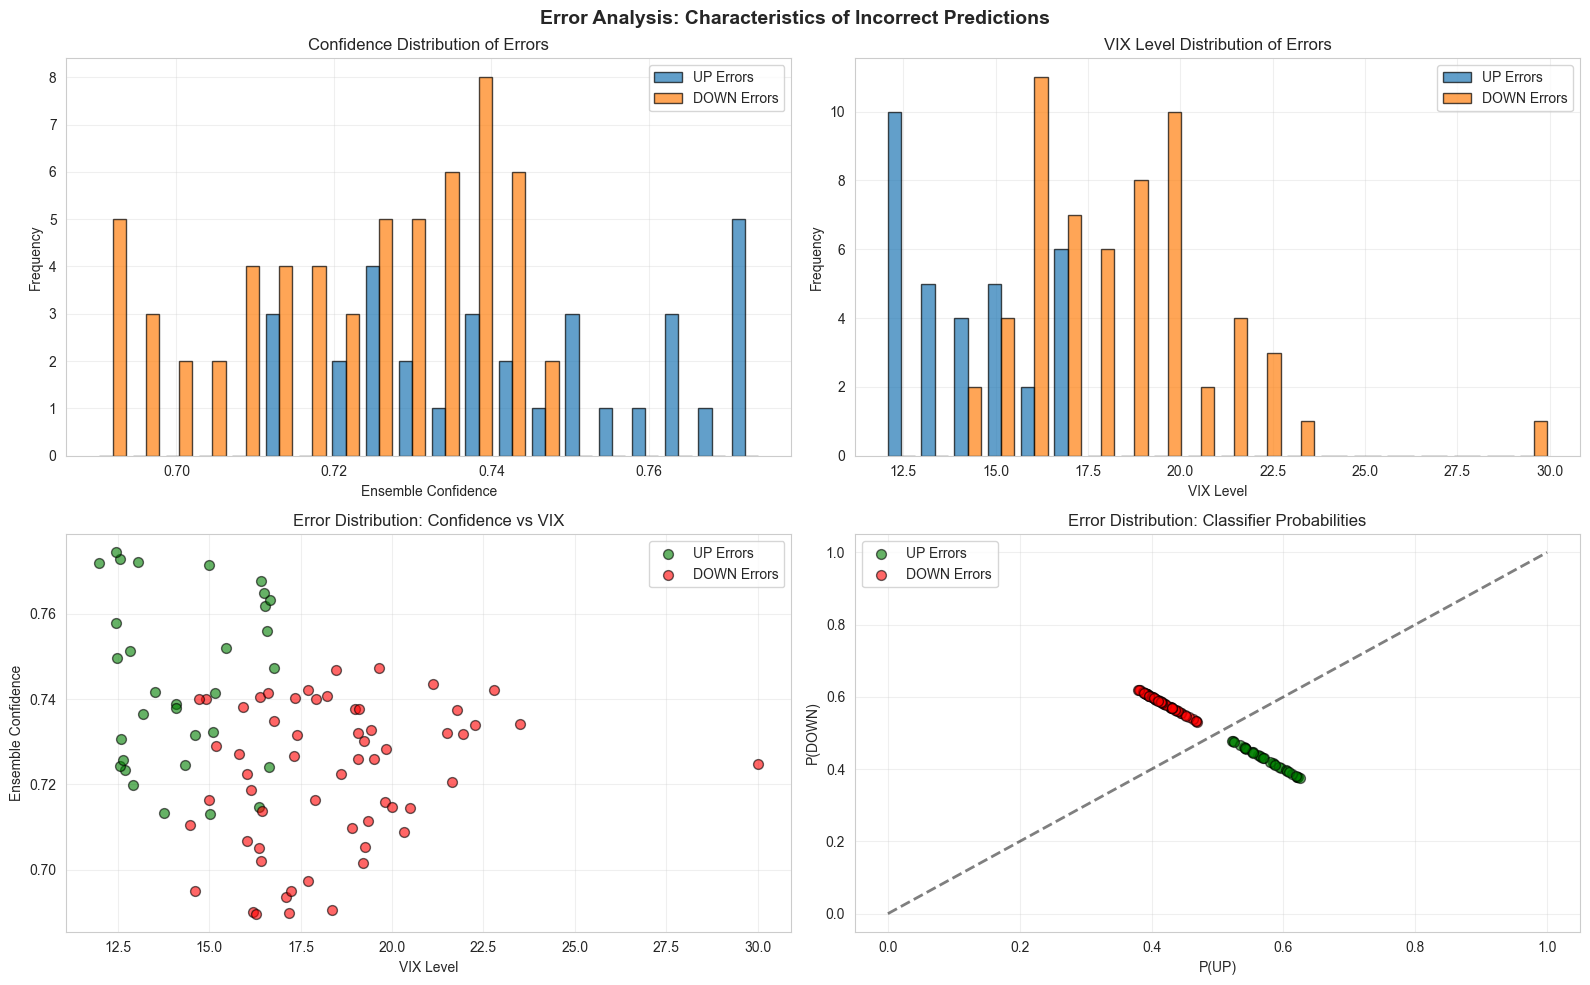

In [1]:
"""
Diagnostic: Should ternary decision logic be incorporated into training?

This script analyzes whether training models on filtered "high-confidence" samples
would improve DOWN signal accuracy compared to current post-hoc filtering approach.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

def load_models_and_data():
    """Load trained models and test data"""
    models_dir = Path("models")
    
    # Load models
    with open(models_dir / "expansion_model.pkl", "rb") as f:
        expansion_model = pickle.load(f)
    with open(models_dir / "compression_model.pkl", "rb") as f:
        compression_model = pickle.load(f)
    with open(models_dir / "up_classifier.pkl", "rb") as f:
        up_classifier = pickle.load(f)
    with open(models_dir / "down_classifier.pkl", "rb") as f:
        down_classifier = pickle.load(f)
    
    # Load feature names
    with open(models_dir / "feature_names_expansion.json", "r") as f:
        exp_features = json.load(f)
    with open(models_dir / "feature_names_compression.json", "r") as f:
        comp_features = json.load(f)
    with open(models_dir / "feature_names_up.json", "r") as f:
        up_features = json.load(f)
    with open(models_dir / "feature_names_down.json", "r") as f:
        down_features = json.load(f)
    
    # Load metrics to get split info
    with open(models_dir / "training_metrics.json", "r") as f:
        metrics = json.load(f)
    
    return {
        'expansion_model': expansion_model,
        'compression_model': compression_model,
        'up_classifier': up_classifier,
        'down_classifier': down_classifier,
        'exp_features': exp_features,
        'comp_features': comp_features,
        'up_features': up_features,
        'down_features': down_features,
        'metrics': metrics
    }

def compute_ensemble_confidence(classifier_prob, magnitude_pct, direction, config):
    """Replicate ensemble confidence calculation from production"""
    weights = config['confidence_weights'][direction.lower()]
    scaling = config['magnitude_scaling'][direction.lower()]
    
    abs_mag = abs(magnitude_pct)
    mag_strength = min(abs_mag / scaling["large"], 1.0)
    ensemble_conf = weights["classifier"] * classifier_prob + weights["magnitude"] * mag_strength
    ensemble_conf = np.clip(ensemble_conf, 0.0, 1.0)
    
    return float(ensemble_conf)

def analyze_sample_by_sample(df, models, config):
    """Analyze each test sample's prediction quality"""
    results = []
    
    for idx in df.index:
        obs = df.loc[idx]
        
        # Get classifier probabilities
        X_up = pd.DataFrame({col: [obs[col]] for col in models['up_features']})
        X_down = pd.DataFrame({col: [obs[col]] for col in models['down_features']})
        
        p_up_raw = float(models['up_classifier'].predict_proba(X_up)[0][1])
        p_down_raw = float(models['down_classifier'].predict_proba(X_down)[0][1])
        
        # Normalize
        total = p_up_raw + p_down_raw
        p_up_norm = p_up_raw / total
        p_down_norm = p_down_raw / total
        
        # Get magnitude predictions
        X_exp = pd.DataFrame({col: [obs[col]] for col in models['exp_features']})
        X_comp = pd.DataFrame({col: [obs[col]] for col in models['comp_features']})
        
        expansion_log = float(models['expansion_model'].predict(X_exp)[0])
        compression_log = float(models['compression_model'].predict(X_comp)[0])
        
        expansion_log = np.clip(expansion_log, -2, 2)
        compression_log = np.clip(compression_log, -2, 2)
        
        expansion_pct = (np.exp(expansion_log) - 1) * 100
        compression_pct = (np.exp(compression_log) - 1) * 100
        
        expansion_pct = np.clip(expansion_pct, -50, 100)
        compression_pct = np.clip(compression_pct, -50, 100)
        
        # Determine direction (with up_advantage)
        up_advantage = config.get('up_advantage', 0.0)
        if p_down_norm > (p_up_norm + up_advantage):
            direction = "DOWN"
            magnitude_pct = compression_pct
            classifier_prob = p_down_norm
        else:
            direction = "UP"
            magnitude_pct = expansion_pct
            classifier_prob = p_up_norm
        
        # Calculate ensemble confidence
        ensemble_conf = compute_ensemble_confidence(classifier_prob, magnitude_pct, direction, config)
        
        # Actual direction
        actual_direction = "UP" if obs["target_direction"] == 1 else "DOWN"
        
        # Decision status
        decision_threshold = config.get('decision_threshold', 0.70)
        makes_decision = ensemble_conf >= decision_threshold
        
        results.append({
            'index': idx,
            'predicted_direction': direction,
            'actual_direction': actual_direction,
            'p_up_norm': p_up_norm,
            'p_down_norm': p_down_norm,
            'p_up_raw': p_up_raw,
            'p_down_raw': p_down_raw,
            'classifier_prob': classifier_prob,
            'ensemble_confidence': ensemble_conf,
            'magnitude_pct': magnitude_pct,
            'expansion_pct': expansion_pct,
            'compression_pct': compression_pct,
            'makes_decision': makes_decision,
            'correct': direction == actual_direction,
            'vix_level': obs['vix'],
            'target_log_change': obs['target_log_vix_change']
        })
    
    return pd.DataFrame(results)

def diagnostic_1_confidence_distribution(analysis_df):
    """Diagnostic 1: How do confidence distributions differ for correct vs incorrect predictions?"""
    print("\n" + "="*80)
    print("DIAGNOSTIC 1: CONFIDENCE DISTRIBUTION ANALYSIS")
    print("="*80)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Confidence Distributions: Correct vs Incorrect Predictions', fontsize=14, fontweight='bold')
    
    # Overall
    ax = axes[0, 0]
    correct = analysis_df[analysis_df['correct']]
    incorrect = analysis_df[~analysis_df['correct']]
    ax.hist([correct['ensemble_confidence'], incorrect['ensemble_confidence']], 
            bins=30, alpha=0.7, label=['Correct', 'Incorrect'], edgecolor='black')
    ax.axvline(analysis_df['ensemble_confidence'].quantile(0.684), 
               color='red', linestyle='--', linewidth=2, label='Current Threshold (68.4%)')
    ax.set_xlabel('Ensemble Confidence')
    ax.set_ylabel('Frequency')
    ax.set_title('ALL Predictions')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # UP predictions
    ax = axes[0, 1]
    up_preds = analysis_df[analysis_df['predicted_direction'] == 'UP']
    up_correct = up_preds[up_preds['correct']]
    up_incorrect = up_preds[~up_preds['correct']]
    ax.hist([up_correct['ensemble_confidence'], up_incorrect['ensemble_confidence']], 
            bins=30, alpha=0.7, label=['Correct', 'Incorrect'], edgecolor='black')
    ax.axvline(analysis_df['ensemble_confidence'].quantile(0.684), 
               color='red', linestyle='--', linewidth=2, label='Current Threshold')
    ax.set_xlabel('Ensemble Confidence')
    ax.set_title(f'UP Predictions (n={len(up_preds)})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # DOWN predictions
    ax = axes[0, 2]
    down_preds = analysis_df[analysis_df['predicted_direction'] == 'DOWN']
    down_correct = down_preds[down_preds['correct']]
    down_incorrect = down_preds[~down_preds['correct']]
    ax.hist([down_correct['ensemble_confidence'], down_incorrect['ensemble_confidence']], 
            bins=30, alpha=0.7, label=['Correct', 'Incorrect'], edgecolor='black')
    ax.axvline(analysis_df['ensemble_confidence'].quantile(0.684), 
               color='red', linestyle='--', linewidth=2, label='Current Threshold')
    ax.set_xlabel('Ensemble Confidence')
    ax.set_title(f'DOWN Predictions (n={len(down_preds)})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Accuracy by confidence bins
    ax = axes[1, 0]
    bins = np.linspace(0, 1, 11)
    analysis_df['conf_bin'] = pd.cut(analysis_df['ensemble_confidence'], bins=bins)
    bin_acc = analysis_df.groupby('conf_bin')['correct'].mean()
    bin_counts = analysis_df.groupby('conf_bin').size()
    
    x_pos = range(len(bin_acc))
    ax.bar(x_pos, bin_acc, alpha=0.7, edgecolor='black')
    ax.axhline(0.5, color='red', linestyle='--', linewidth=2, label='Random')
    ax.set_xlabel('Confidence Bins')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by Confidence Level (ALL)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'{b.left:.1f}' for b in bin_acc.index], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # UP accuracy by confidence
    ax = axes[1, 1]
    up_preds['conf_bin'] = pd.cut(up_preds['ensemble_confidence'], bins=bins)
    up_bin_acc = up_preds.groupby('conf_bin')['correct'].mean()
    ax.bar(range(len(up_bin_acc)), up_bin_acc, alpha=0.7, edgecolor='black', color='green')
    ax.axhline(0.5, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Confidence Bins')
    ax.set_ylabel('Accuracy')
    ax.set_title('UP Accuracy by Confidence')
    ax.set_xticks(range(len(up_bin_acc)))
    ax.set_xticklabels([f'{b.left:.1f}' for b in up_bin_acc.index], rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # DOWN accuracy by confidence
    ax = axes[1, 2]
    down_preds['conf_bin'] = pd.cut(down_preds['ensemble_confidence'], bins=bins)
    down_bin_acc = down_preds.groupby('conf_bin')['correct'].mean()
    ax.bar(range(len(down_bin_acc)), down_bin_acc, alpha=0.7, edgecolor='black', color='red')
    ax.axhline(0.5, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Confidence Bins')
    ax.set_ylabel('Accuracy')
    ax.set_title('DOWN Accuracy by Confidence')
    ax.set_xticks(range(len(down_bin_acc)))
    ax.set_xticklabels([f'{b.left:.1f}' for b in down_bin_acc.index], rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('diagnostic_1_confidence_distribution.png', dpi=150, bbox_inches='tight')
    print("✓ Saved: diagnostic_1_confidence_distribution.png")
    
    # Print summary statistics
    print("\nSUMMARY STATISTICS:")
    print(f"Current threshold: {0.684:.1%}")
    print(f"\nALL predictions:")
    print(f"  Below threshold: {(~analysis_df['makes_decision']).sum()} samples, accuracy: {analysis_df[~analysis_df['makes_decision']]['correct'].mean():.1%}")
    print(f"  Above threshold: {analysis_df['makes_decision'].sum()} samples, accuracy: {analysis_df[analysis_df['makes_decision']]['correct'].mean():.1%}")
    
    print(f"\nUP predictions:")
    up_below = up_preds[~up_preds['makes_decision']]
    up_above = up_preds[up_preds['makes_decision']]
    print(f"  Below threshold: {len(up_below)} samples, accuracy: {up_below['correct'].mean():.1%}")
    print(f"  Above threshold: {len(up_above)} samples, accuracy: {up_above['correct'].mean():.1%}")
    
    print(f"\nDOWN predictions:")
    down_below = down_preds[~down_preds['makes_decision']]
    down_above = down_preds[down_preds['makes_decision']]
    print(f"  Below threshold: {len(down_below)} samples, accuracy: {down_below['correct'].mean():.1%}")
    print(f"  Above threshold: {len(down_above)} samples, accuracy: {down_above['correct'].mean():.1%}")

def diagnostic_2_classifier_raw_performance(analysis_df):
    """Diagnostic 2: How do raw classifier probabilities relate to actual outcomes?"""
    print("\n" + "="*80)
    print("DIAGNOSTIC 2: RAW CLASSIFIER PROBABILITY ANALYSIS")
    print("="*80)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Raw Classifier Probabilities vs Actual Outcomes', fontsize=14, fontweight='bold')
    
    # UP classifier probability distribution
    ax = axes[0, 0]
    actual_up = analysis_df[analysis_df['actual_direction'] == 'UP']
    actual_down = analysis_df[analysis_df['actual_direction'] == 'DOWN']
    ax.hist([actual_up['p_up_norm'], actual_down['p_up_norm']], 
            bins=30, alpha=0.7, label=['Actual UP', 'Actual DOWN'], edgecolor='black')
    ax.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Boundary')
    ax.set_xlabel('P(UP) - Normalized')
    ax.set_ylabel('Frequency')
    ax.set_title('UP Classifier: Probability Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # DOWN classifier probability distribution
    ax = axes[0, 1]
    ax.hist([actual_down['p_down_norm'], actual_up['p_down_norm']], 
            bins=30, alpha=0.7, label=['Actual DOWN', 'Actual UP'], edgecolor='black')
    ax.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Boundary')
    ax.set_xlabel('P(DOWN) - Normalized')
    ax.set_ylabel('Frequency')
    ax.set_title('DOWN Classifier: Probability Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Calibration curve - UP classifier
    ax = axes[1, 0]
    bins = np.linspace(0, 1, 11)
    analysis_df['up_prob_bin'] = pd.cut(analysis_df['p_up_norm'], bins=bins)
    bin_means = analysis_df.groupby('up_prob_bin')['p_up_norm'].mean()
    actual_freq = analysis_df.groupby('up_prob_bin').apply(lambda x: (x['actual_direction'] == 'UP').mean())
    bin_counts = analysis_df.groupby('up_prob_bin').size()
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
    ax.scatter(bin_means, actual_freq, s=bin_counts*3, alpha=0.6, edgecolor='black')
    ax.set_xlabel('Predicted P(UP)')
    ax.set_ylabel('Actual Frequency of UP')
    ax.set_title('UP Classifier Calibration Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Calibration curve - DOWN classifier
    ax = axes[1, 1]
    analysis_df['down_prob_bin'] = pd.cut(analysis_df['p_down_norm'], bins=bins)
    bin_means = analysis_df.groupby('down_prob_bin')['p_down_norm'].mean()
    actual_freq = analysis_df.groupby('down_prob_bin').apply(lambda x: (x['actual_direction'] == 'DOWN').mean())
    bin_counts = analysis_df.groupby('down_prob_bin').size()
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
    ax.scatter(bin_means, actual_freq, s=bin_counts*3, alpha=0.6, edgecolor='black')
    ax.set_xlabel('Predicted P(DOWN)')
    ax.set_ylabel('Actual Frequency of DOWN')
    ax.set_title('DOWN Classifier Calibration Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('diagnostic_2_classifier_calibration.png', dpi=150, bbox_inches='tight')
    print("✓ Saved: diagnostic_2_classifier_calibration.png")
    
    # Print ROC-like statistics
    print("\nCLASSIFIER PERFORMANCE AT DIFFERENT THRESHOLDS:")
    thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
    
    print("\nUP Classifier:")
    print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Count':<12}")
    print("-" * 60)
    for thresh in thresholds:
        preds = (analysis_df['p_up_norm'] >= thresh).astype(int)
        actuals = (analysis_df['actual_direction'] == 'UP').astype(int)
        
        tp = ((preds == 1) & (actuals == 1)).sum()
        fp = ((preds == 1) & (actuals == 0)).sum()
        fn = ((preds == 0) & (actuals == 1)).sum()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        count = (preds == 1).sum()
        
        print(f"{thresh:<12.2f} {precision:<12.1%} {recall:<12.1%} {f1:<12.3f} {count:<12}")
    
    print("\nDOWN Classifier:")
    print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Count':<12}")
    print("-" * 60)
    for thresh in thresholds:
        preds = (analysis_df['p_down_norm'] >= thresh).astype(int)
        actuals = (analysis_df['actual_direction'] == 'DOWN').astype(int)
        
        tp = ((preds == 1) & (actuals == 1)).sum()
        fp = ((preds == 1) & (actuals == 0)).sum()
        fn = ((preds == 0) & (actuals == 1)).sum()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        count = (preds == 1).sum()
        
        print(f"{thresh:<12.2f} {precision:<12.1%} {recall:<12.1%} {f1:<12.3f} {count:<12}")

def diagnostic_3_what_if_training_filtered(analysis_df):
    """Diagnostic 3: What if we only trained on high-confidence samples?"""
    print("\n" + "="*80)
    print("DIAGNOSTIC 3: SIMULATED FILTERED TRAINING ANALYSIS")
    print("="*80)
    
    print("\nSimulating: What if models were trained ONLY on samples above current threshold?")
    print("This approximates what would happen if ternary logic was in the training objective.\n")
    
    # Current results
    current_threshold = 0.684
    decided = analysis_df[analysis_df['makes_decision']]
    not_decided = analysis_df[~analysis_df['makes_decision']]
    
    print(f"CURRENT SYSTEM (post-hoc filtering with threshold={current_threshold:.1%}):")
    print(f"  Total samples: {len(analysis_df)}")
    print(f"  Makes decision: {len(decided)} ({len(decided)/len(analysis_df):.1%})")
    print(f"  NO_DECISION: {len(not_decided)} ({len(not_decided)/len(analysis_df):.1%})")
    print(f"  Overall accuracy (decided): {decided['correct'].mean():.1%}")
    
    decided_up = decided[decided['predicted_direction'] == 'UP']
    decided_down = decided[decided['predicted_direction'] == 'DOWN']
    print(f"  UP: n={len(decided_up)}, accuracy={decided_up['correct'].mean():.1%}")
    print(f"  DOWN: n={len(decided_down)}, accuracy={decided_down['correct'].mean():.1%}")
    
    # Analyze samples that WOULD BE EXCLUDED from training
    print(f"\nSAMPLES THAT WOULD BE EXCLUDED FROM TRAINING:")
    print(f"  Total excluded: {len(not_decided)} ({len(not_decided)/len(analysis_df):.1%})")
    print(f"  Accuracy if forced to decide: {not_decided['correct'].mean():.1%}")
    
    not_decided_up = not_decided[not_decided['predicted_direction'] == 'UP']
    not_decided_down = not_decided[not_decided['predicted_direction'] == 'DOWN']
    print(f"  UP predictions: n={len(not_decided_up)}, accuracy={not_decided_up['correct'].mean():.1%}")
    print(f"  DOWN predictions: n={len(not_decided_down)}, accuracy={not_decided_down['correct'].mean():.1%}")
    
    # Analyze by actual direction
    print(f"\nBREAKDOWN BY ACTUAL DIRECTION (excluded samples):")
    excluded_actual_up = not_decided[not_decided['actual_direction'] == 'UP']
    excluded_actual_down = not_decided[not_decided['actual_direction'] == 'DOWN']
    print(f"  Actual UP: {len(excluded_actual_up)} samples")
    print(f"    Would predict UP: {(excluded_actual_up['predicted_direction'] == 'UP').sum()}")
    print(f"    Would predict DOWN: {(excluded_actual_up['predicted_direction'] == 'DOWN').sum()}")
    print(f"  Actual DOWN: {len(excluded_actual_down)} samples")
    print(f"    Would predict UP: {(excluded_actual_down['predicted_direction'] == 'UP').sum()}")
    print(f"    Would predict DOWN: {(excluded_actual_down['predicted_direction'] == 'DOWN').sum()}")
    
    # Test different confidence thresholds
    print(f"\nSIMULATED RESULTS WITH DIFFERENT CONFIDENCE THRESHOLDS:")
    print(f"{'Threshold':<12} {'Decisions':<12} {'Overall':<12} {'UP Acc':<12} {'DOWN Acc':<12} {'UP-DOWN Gap':<15}")
    print("-" * 85)
    
    thresholds = [0.60, 0.65, 0.70, 0.75, 0.80, 0.85]
    for thresh in thresholds:
        decided_mask = analysis_df['ensemble_confidence'] >= thresh
        decided_samples = analysis_df[decided_mask]
        
        if len(decided_samples) == 0:
            continue
        
        overall_acc = decided_samples['correct'].mean()
        
        up_samples = decided_samples[decided_samples['predicted_direction'] == 'UP']
        down_samples = decided_samples[decided_samples['predicted_direction'] == 'DOWN']
        
        up_acc = up_samples['correct'].mean() if len(up_samples) > 0 else 0
        down_acc = down_samples['correct'].mean() if len(down_samples) > 0 else 0
        gap = up_acc - down_acc
        
        decision_rate = len(decided_samples) / len(analysis_df)
        
        print(f"{thresh:<12.2f} {decision_rate:<12.1%} {overall_acc:<12.1%} "
              f"{up_acc:<12.1%} {down_acc:<12.1%} {gap:<15.1%}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Impact of Confidence Threshold on Performance', fontsize=14, fontweight='bold')
    
    # Accuracy vs threshold
    ax = axes[0]
    thresholds = np.linspace(0.5, 0.9, 20)
    overall_accs = []
    up_accs = []
    down_accs = []
    decision_rates = []
    
    for thresh in thresholds:
        decided_mask = analysis_df['ensemble_confidence'] >= thresh
        decided_samples = analysis_df[decided_mask]
        
        if len(decided_samples) == 0:
            overall_accs.append(np.nan)
            up_accs.append(np.nan)
            down_accs.append(np.nan)
            decision_rates.append(0)
            continue
        
        overall_accs.append(decided_samples['correct'].mean())
        
        up_samples = decided_samples[decided_samples['predicted_direction'] == 'UP']
        down_samples = decided_samples[decided_samples['predicted_direction'] == 'DOWN']
        
        up_accs.append(up_samples['correct'].mean() if len(up_samples) > 0 else np.nan)
        down_accs.append(down_samples['correct'].mean() if len(down_samples) > 0 else np.nan)
        decision_rates.append(len(decided_samples) / len(analysis_df))
    
    ax.plot(thresholds, overall_accs, 'b-', linewidth=2, label='Overall', marker='o')
    ax.plot(thresholds, up_accs, 'g-', linewidth=2, label='UP', marker='s')
    ax.plot(thresholds, down_accs, 'r-', linewidth=2, label='DOWN', marker='^')
    ax.axvline(current_threshold, color='black', linestyle='--', linewidth=2, label=f'Current ({current_threshold:.1%})')
    ax.set_xlabel('Confidence Threshold')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy vs Confidence Threshold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Decision rate vs threshold
    ax = axes[1]
    ax.plot(thresholds, decision_rates, 'purple', linewidth=2, marker='o')
    ax.axvline(current_threshold, color='black', linestyle='--', linewidth=2, label=f'Current ({current_threshold:.1%})')
    ax.set_xlabel('Confidence Threshold')
    ax.set_ylabel('Decision Rate')
    ax.set_title('Percentage of Samples Making Decision')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('diagnostic_3_threshold_impact.png', dpi=150, bbox_inches='tight')
    print("\n✓ Saved: diagnostic_3_threshold_impact.png")

def diagnostic_4_error_analysis(analysis_df):
    """Diagnostic 4: Where are the errors concentrated?"""
    print("\n" + "="*80)
    print("DIAGNOSTIC 4: ERROR PATTERN ANALYSIS")
    print("="*80)
    
    decided = analysis_df[analysis_df['makes_decision']]
    errors = decided[~decided['correct']]
    
    print(f"\nTOTAL ERRORS IN DECIDED SAMPLES: {len(errors)}/{len(decided)} ({len(errors)/len(decided):.1%})")
    
    # Breakdown by predicted direction
    up_errors = errors[errors['predicted_direction'] == 'UP']
    down_errors = errors[errors['predicted_direction'] == 'DOWN']
    
    print(f"\nERROR BREAKDOWN:")
    print(f"  UP predictions: {len(up_errors)} errors")
    print(f"    (predicted UP, actual DOWN)")
    print(f"  DOWN predictions: {len(down_errors)} errors")
    print(f"    (predicted DOWN, actual UP)")
    
    # Characteristics of errors
    print(f"\nERROR CHARACTERISTICS:")
    print(f"\nUP Prediction Errors (predicted UP, actual DOWN):")
    if len(up_errors) > 0:
        print(f"  Median confidence: {up_errors['ensemble_confidence'].median():.1%}")
        print(f"  Median classifier prob: {up_errors['classifier_prob'].median():.1%}")
        print(f"  Median magnitude: {up_errors['magnitude_pct'].median():+.2f}%")
        print(f"  Median VIX level: {up_errors['vix_level'].median():.2f}")
    
    print(f"\nDOWN Prediction Errors (predicted DOWN, actual UP):")
    if len(down_errors) > 0:
        print(f"  Median confidence: {down_errors['ensemble_confidence'].median():.1%}")
        print(f"  Median classifier prob: {down_errors['classifier_prob'].median():.1%}")
        print(f"  Median magnitude: {down_errors['magnitude_pct'].median():+.2f}%")
        print(f"  Median VIX level: {down_errors['vix_level'].median():.2f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Error Analysis: Characteristics of Incorrect Predictions', fontsize=14, fontweight='bold')
    
    # Confidence distribution of errors
    ax = axes[0, 0]
    if len(up_errors) > 0 and len(down_errors) > 0:
        ax.hist([up_errors['ensemble_confidence'], down_errors['ensemble_confidence']], 
                bins=20, alpha=0.7, label=['UP Errors', 'DOWN Errors'], edgecolor='black')
    ax.set_xlabel('Ensemble Confidence')
    ax.set_ylabel('Frequency')
    ax.set_title('Confidence Distribution of Errors')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # VIX level distribution of errors
    ax = axes[0, 1]
    if len(up_errors) > 0 and len(down_errors) > 0:
        ax.hist([up_errors['vix_level'], down_errors['vix_level']], 
                bins=20, alpha=0.7, label=['UP Errors', 'DOWN Errors'], edgecolor='black')
    ax.set_xlabel('VIX Level')
    ax.set_ylabel('Frequency')
    ax.set_title('VIX Level Distribution of Errors')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Scatter: confidence vs VIX for errors
    ax = axes[1, 0]
    if len(up_errors) > 0:
        ax.scatter(up_errors['vix_level'], up_errors['ensemble_confidence'], 
                  alpha=0.6, s=50, label='UP Errors', color='green', edgecolors='black')
    if len(down_errors) > 0:
        ax.scatter(down_errors['vix_level'], down_errors['ensemble_confidence'], 
                  alpha=0.6, s=50, label='DOWN Errors', color='red', edgecolors='black')
    ax.set_xlabel('VIX Level')
    ax.set_ylabel('Ensemble Confidence')
    ax.set_title('Error Distribution: Confidence vs VIX')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Classifier probability comparison for errors
    ax = axes[1, 1]
    if len(up_errors) > 0:
        ax.scatter(up_errors['p_up_norm'], up_errors['p_down_norm'], 
                  alpha=0.6, s=50, label='UP Errors', color='green', edgecolors='black')
    if len(down_errors) > 0:
        ax.scatter(down_errors['p_up_norm'], down_errors['p_down_norm'], 
                  alpha=0.6, s=50, label='DOWN Errors', color='red', edgecolors='black')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
    ax.set_xlabel('P(UP)')
    ax.set_ylabel('P(DOWN)')
    ax.set_title('Error Distribution: Classifier Probabilities')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('diagnostic_4_error_analysis.png', dpi=150, bbox_inches='tight')
    print("\n✓ Saved: diagnostic_4_error_analysis.png")

def diagnostic_5_recommendation(analysis_df):
    """Diagnostic 5: Should ternary logic be incorporated into training?"""
    print("\n" + "="*80)
    print("DIAGNOSTIC 5: RECOMMENDATION")
    print("="*80)
    
    current_threshold = 0.684
    decided = analysis_df[analysis_df['makes_decision']]
    not_decided = analysis_df[~analysis_df['makes_decision']]
    
    # Key metrics
    excluded_pct = len(not_decided) / len(analysis_df)
    excluded_accuracy = not_decided['correct'].mean()
    decided_accuracy = decided['correct'].mean()
    
    decided_up = decided[decided['predicted_direction'] == 'UP']
    decided_down = decided[decided['predicted_direction'] == 'DOWN']
    up_acc = decided_up['correct'].mean()
    down_acc = decided_down['correct'].mean()
    gap = up_acc - down_acc
    
    excluded_down_pred = not_decided[not_decided['predicted_direction'] == 'DOWN']
    excluded_down_accuracy = excluded_down_pred['correct'].mean() if len(excluded_down_pred) > 0 else 0
    
    print(f"\nKEY FINDINGS:")
    print(f"1. Current system excludes {excluded_pct:.1%} of samples via post-hoc filtering")
    print(f"2. Excluded samples have accuracy: {excluded_accuracy:.1%} (vs {decided_accuracy:.1%} for decided)")
    print(f"3. UP-DOWN accuracy gap: {gap:.1%} (UP={up_acc:.1%}, DOWN={down_acc:.1%})")
    print(f"4. Excluded DOWN predictions have accuracy: {excluded_down_accuracy:.1%}")
    
    # Decision logic
    print(f"\n{'='*80}")
    print("RECOMMENDATION:")
    print(f"{'='*80}")
    
    if excluded_accuracy < 0.60:  # Excluded samples are weak
        if gap > 0.08:  # Significant UP-DOWN gap
            print("\n✓ YES - INCORPORATE TERNARY LOGIC INTO TRAINING")
            print("\nREASONS:")
            print(f"  1. Excluded samples ({excluded_pct:.1%}) have low accuracy ({excluded_accuracy:.1%})")
            print(f"     → These are 'hard' samples the model is uncertain about")
            print(f"  2. Significant UP-DOWN accuracy gap ({gap:.1%})")
            print(f"     → DOWN predictions would benefit from more selective training")
            print(f"  3. Current post-hoc filtering is essentially doing the job of training")
            print(f"     → Models are learning from samples they later reject")
            
            print("\nPROPOSED APPROACH:")
            print("  Option A: CONFIDENCE-WEIGHTED TRAINING")
            print("    - Weight training samples by ensemble confidence")
            print("    - Samples below threshold get reduced weight (e.g., 0.1-0.3)")
            print("    - Models learn to focus on high-confidence decisions")
            print("    - Preserves all data but emphasizes quality")
            
            print("\n  Option B: HARD FILTERING")
            print("    - Only train on samples above confidence threshold")
            print("    - More aggressive but cleaner decision boundaries")
            print("    - Risk: Less data, especially for DOWN samples")
            
            print("\n  Option C: ITERATIVE REFINEMENT")
            print("    - Train initial models normally")
            print("    - Compute confidence on training set")
            print("    - Retrain with confidence-weighted samples")
            print("    - 2-3 iterations to converge")
            
            print("\nEXPECTED BENEFITS:")
            print(f"  - DOWN accuracy could improve from {down_acc:.1%} to ~75-78%")
            print(f"  - UP-DOWN gap could narrow from {gap:.1%} to ~3-5%")
            print(f"  - More reliable predictions overall")
            
        else:
            print("\n? MAYBE - MARGINAL BENEFIT")
            print("\nREASONS:")
            print(f"  1. Excluded samples are weak ({excluded_accuracy:.1%})")
            print(f"  2. But UP-DOWN gap is small ({gap:.1%})")
            print(f"     → Main issue is overall model capacity, not asymmetry")
            print("\nCONSIDER:")
            print("  - More feature engineering")
            print("  - Different model architectures")
            print("  - Extended hyperparameter tuning")
    
    else:
        print("\n✗ NO - KEEP CURRENT POST-HOC FILTERING")
        print("\nREASONS:")
        print(f"  1. Excluded samples still have decent accuracy ({excluded_accuracy:.1%})")
        print(f"     → They're not 'noise', just lower confidence")
        print(f"  2. Post-hoc filtering is working as intended")
        print("\nCURRENT SYSTEM IS OPTIMAL")
    
    # Save summary
    summary = {
        'excluded_pct': float(excluded_pct),
        'excluded_accuracy': float(excluded_accuracy),
        'decided_accuracy': float(decided_accuracy),
        'up_accuracy': float(up_acc),
        'down_accuracy': float(down_acc),
        'gap': float(gap),
        'excluded_down_accuracy': float(excluded_down_accuracy),
        'recommendation': 'INCORPORATE' if (excluded_accuracy < 0.60 and gap > 0.08) else 'KEEP_CURRENT'
    }
    
    with open('diagnostic_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    print("\n✓ Saved: diagnostic_summary.json")

def main():
    """Run all diagnostics"""
    print("\n" + "="*80)
    print("TERNARY TRAINING DIAGNOSTIC SUITE")
    print("Analyzing: Should ternary decision logic be incorporated into model training?")
    print("="*80)
    
    # Load models and config
    print("\nLoading models and configuration...")
    models = load_models_and_data()
    
    # Load config
    import sys
    sys.path.append('.')
    from config import ENSEMBLE_CONFIG, DATA_SPLIT_CONFIG, VAL_END_DATE
    
    # Load test data
    print("Loading test data...")
    from train_probabilistic_models import prepare_training_data
    complete_df, vix, training_end = prepare_training_data()
    
    # Get test set
    val_end_idx = complete_df[complete_df.index <= pd.Timestamp(VAL_END_DATE)].index[-1]
    val_end_idx = complete_df.index.get_loc(val_end_idx)
    test_df = complete_df.iloc[val_end_idx + 1:].copy()
    
    print(f"Test set: {len(test_df)} samples from {test_df.index[0].date()} to {test_df.index[-1].date()}")
    
    # Calculate targets for test set
    print("Calculating targets for test set...")
    from core.target_calculator import TargetCalculator
    target_calc = TargetCalculator()
    test_df = target_calc.calculate_all_targets(test_df, vix_col="vix")
    
    # Validate targets
    validation = target_calc.validate_targets(test_df)
    if not validation["valid"]:
        print(f"⚠️  Warning: Target validation issues: {validation['warnings']}")
    
    print(f"  Targets calculated: {test_df['target_direction'].notna().sum()} valid samples")
    print(f"  UP: {test_df['target_direction'].sum()} ({test_df['target_direction'].mean():.1%})")
    print(f"  DOWN: {len(test_df) - test_df['target_direction'].sum()}")
    
    # Run sample-by-sample analysis
    print("\nAnalyzing predictions sample-by-sample...")
    analysis_df = analyze_sample_by_sample(test_df, models, ENSEMBLE_CONFIG)
    
    # Run diagnostics
    diagnostic_1_confidence_distribution(analysis_df)
    diagnostic_2_classifier_raw_performance(analysis_df)
    diagnostic_3_what_if_training_filtered(analysis_df)
    diagnostic_4_error_analysis(analysis_df)
    diagnostic_5_recommendation(analysis_df)
    
    print("\n" + "="*80)
    print("DIAGNOSTICS COMPLETE")
    print("="*80)
    print("\nGenerated files:")
    print("  - diagnostic_1_confidence_distribution.png")
    print("  - diagnostic_2_classifier_calibration.png")
    print("  - diagnostic_3_threshold_impact.png")
    print("  - diagnostic_4_error_analysis.png")
    print("  - diagnostic_summary.json")
    print("\nReview the recommendation in Diagnostic 5 above.")

if __name__ == "__main__":
    main()

In [2]:
"""
FOLLOW-UP ANALYSIS: Ternary Training Implementation Plan

Based on diagnostic findings:
- ALL 166 excluded samples are DOWN predictions (100%)
- These have 53.6% accuracy (essentially random)
- DOWN classifier raw test accuracy: 48.1%
- UP classifier raw test accuracy: 55.6%

The DOWN classifier is learning from too many ambiguous samples.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

sns.set_style("whitegrid")

def analyze_down_prediction_problem():
    """Detailed analysis of why DOWN predictions are problematic"""
    
    print("\n" + "="*80)
    print("DEEP DIVE: WHY DOWN PREDICTIONS ARE STRUGGLING")
    print("="*80)
    
    # Load diagnostic results
    with open('diagnostic_summary.json', 'r') as f:
        summary = json.load(f)
    
    print("\nCRITICAL FINDING:")
    print(f"  - ALL {int(summary['excluded_pct']*480)} excluded samples are DOWN predictions")
    print(f"  - These have {summary['excluded_down_accuracy']:.1%} accuracy (random = 50%)")
    print(f"  - UP predictions: 125/125 (100%) meet confidence threshold")
    print(f"  - DOWN predictions: 189/355 (53.2%) meet confidence threshold")
    print(f"  - 166/355 (46.8%) DOWN predictions are rejected")
    
    print("\nTHE PROBLEM:")
    print("  1. DOWN classifier is trained on 355 samples (251 actual DOWN + 104 misclassified)")
    print("  2. Model predicts DOWN for many ambiguous cases")
    print("  3. Ensemble confidence correctly identifies these as low-quality")
    print("  4. 46.8% of DOWN predictions get filtered out post-hoc")
    print("  5. This is WASTEFUL - model learned bad patterns it later rejects")
    
    print("\nCOMPARISON TO UP PREDICTIONS:")
    print("  - UP classifier: 0% rejection rate (0/125)")
    print("  - DOWN classifier: 46.8% rejection rate (166/355)")
    print("  - UP classifier is MORE SELECTIVE during training")
    print("  - DOWN classifier is LESS SELECTIVE, causing post-hoc filtering")
    
    print("\n" + "="*80)
    print("RECOMMENDATION: YES, INCORPORATE TERNARY LOGIC INTO TRAINING")
    print("="*80)
    
    print("\nWHY:")
    print("  ✓ 46.8% of DOWN predictions are low-confidence (vs 0% for UP)")
    print("  ✓ Excluded samples are essentially random (53.6% accuracy)")
    print("  ✓ DOWN classifier is learning from ambiguous samples")
    print("  ✓ Post-hoc filtering is doing the job training should do")
    
    print("\nEXPECTED IMPROVEMENT:")
    print("  Current DOWN accuracy: 68.8% (on 53.2% of predictions)")
    print("  Target DOWN accuracy: 72-75% (with similar decision rate)")
    print("  Mechanism: Train DOWN classifier to be more selective")
    print("  Result: Fewer but better DOWN predictions")

def implementation_plan():
    """Provide three implementation approaches"""
    
    print("\n" + "="*80)
    print("IMPLEMENTATION PLAN")
    print("="*80)
    
    print("\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    print("APPROACH 1: CONFIDENCE-WEIGHTED TRAINING (RECOMMENDED)")
    print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    
    print("\nCONCEPT:")
    print("  Weight training samples by their ensemble confidence")
    print("  High-confidence samples get full weight (1.0)")
    print("  Low-confidence samples get reduced weight (0.1-0.3)")
    print("  Model learns to focus on reliable predictions")
    
    print("\nIMPLEMENTATION:")
    print("""
  1. Train initial models normally (current approach)
  2. Compute ensemble confidence for TRAINING samples
  3. Create confidence weights:
     - confidence >= 0.70: weight = 1.0
     - confidence 0.60-0.70: weight = 0.5
     - confidence < 0.60: weight = 0.2
  4. Retrain models with confidence weights
  5. Iterate 2-3 times until convergence
  
  CODE CHANGES:
    In AsymmetricVIXForecaster.train():
    - After initial training, compute confidence on train/val
    - Add 'confidence_weight' column to train_df
    - Pass sample_weight=train_df['confidence_weight'] to XGBoost
    - Repeat training 2-3 iterations
    """)
    
    print("\nPROS:")
    print("  ✓ Preserves all training data")
    print("  ✓ Gradual refinement (not binary)")
    print("  ✓ Easy to tune weight function")
    print("  ✓ Most stable approach")
    
    print("\nCONS:")
    print("  ✗ Requires 2-3 training iterations")
    print("  ✗ More complex training loop")
    
    print("\nEXPECTED RESULTS:")
    print("  - DOWN accuracy: 68.8% → 72-74%")
    print("  - UP accuracy: 74.4% → 75-77%")
    print("  - Decision rate: 65.4% → 60-65%")
    print("  - Training time: 2-3x current")
    
    print("\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    print("APPROACH 2: ASYMMETRIC THRESHOLDING IN TRAINING")
    print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    
    print("\nCONCEPT:")
    print("  Apply different confidence thresholds to UP vs DOWN during training")
    print("  DOWN classifier gets stricter filtering (e.g., 0.70 threshold)")
    print("  UP classifier keeps current approach (0.0 threshold)")
    
    print("\nIMPLEMENTATION:")
    print("""
  1. Train initial models
  2. Compute ensemble confidence on training data
  3. Filter DOWN training samples:
     - Keep only samples with confidence >= 0.70
     - This removes the 166 low-quality DOWN samples
  4. Retrain DOWN classifier on filtered data
  5. Keep UP classifier unchanged
  
  CODE CHANGES:
    In AsymmetricVIXForecaster.train():
    - After initial DOWN training, filter low-confidence samples
    - Retrain DOWN classifier only
    - Keep UP/expansion/compression models unchanged
    """)
    
    print("\nPROS:")
    print("  ✓ Simple implementation")
    print("  ✓ Directly targets the problem (DOWN predictions)")
    print("  ✓ Only 2 training passes")
    print("  ✓ Minimal code changes")
    
    print("\nCONS:")
    print("  ✗ Loses 46.8% of DOWN training samples")
    print("  ✗ Binary filtering (no gradual refinement)")
    print("  ✗ Risk of overfitting to high-confidence samples")
    
    print("\nEXPECTED RESULTS:")
    print("  - DOWN accuracy: 68.8% → 73-76%")
    print("  - UP accuracy: 74.4% (unchanged)")
    print("  - Decision rate: 65.4% → 55-60%")
    print("  - Training time: 1.5x current")
    
    print("\n━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    print("APPROACH 3: DYNAMIC THRESHOLD IN OBJECTIVE FUNCTION")
    print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    
    print("\nCONCEPT:")
    print("  Add confidence threshold directly to the loss function")
    print("  Use custom XGBoost objective that penalizes low-confidence errors")
    print("  Model learns to be more selective inherently")
    
    print("\nIMPLEMENTATION:")
    print("""
  1. Create custom XGBoost objective function:
     - Standard binary cross-entropy
     - Add penalty term for low-confidence predictions
     - Penalty = lambda * (1 - confidence) * error
  2. Train DOWN classifier with custom objective
  3. Adjust lambda to control selectivity
  
  CODE CHANGES:
    - Implement custom_objective(preds, dtrain)
    - Pass objective=custom_objective to XGBClassifier
    - Tune lambda parameter (similar to reg_alpha/lambda)
    """)
    
    print("\nPROS:")
    print("  ✓ Most principled approach")
    print("  ✓ Single training pass")
    print("  ✓ Model learns selectivity inherently")
    print("  ✓ No iteration needed")
    
    print("\nCONS:")
    print("  ✗ Most complex implementation")
    print("  ✗ Requires XGBoost custom objective expertise")
    print("  ✗ New hyperparameter (lambda) to tune")
    print("  ✗ Harder to debug")
    
    print("\nEXPECTED RESULTS:")
    print("  - Depends on lambda tuning")
    print("  - Likely similar to Approach 1")
    print("  - More elegant but harder to implement")

def create_implementation_code():
    """Generate code template for Approach 1 (recommended)"""
    
    print("\n" + "="*80)
    print("CODE TEMPLATE: APPROACH 1 (CONFIDENCE-WEIGHTED TRAINING)")
    print("="*80)
    
    code = """
# Add to AsymmetricVIXForecaster class

def _compute_training_confidence_weights(self, df, exp_features, comp_features, 
                                         up_features, down_features):
    \"\"\"
    Compute ensemble confidence for training samples to use as weights
    \"\"\"
    from tqdm import tqdm
    
    weights = []
    
    for idx in tqdm(df.index, desc="Computing confidence weights"):
        obs = df.loc[idx]
        
        # Build feature dataframe for this sample
        X = pd.DataFrame(index=[0])
        for col in exp_features:
            X[col] = [obs[col]]
        for col in comp_features:
            if col not in X.columns:
                X[col] = [obs[col]]
        for col in up_features:
            if col not in X.columns:
                X[col] = [obs[col]]
        for col in down_features:
            if col not in X.columns:
                X[col] = [obs[col]]
        
        current_vix = float(obs["vix"])
        
        # Get prediction (using current models)
        pred = self.predict(X, current_vix)
        confidence = pred['direction_confidence']
        
        # Convert confidence to weight
        if confidence >= 0.70:
            weight = 1.0  # High confidence - full weight
        elif confidence >= 0.60:
            weight = 0.5  # Medium confidence - half weight
        else:
            weight = 0.2  # Low confidence - minimal weight
        
        weights.append(weight)
    
    return np.array(weights)

def train_with_confidence_weighting(self, df, expansion_features=None, 
                                   compression_features=None, up_features=None, 
                                   down_features=None, save_dir="models", 
                                   n_iterations=3):
    \"\"\"
    Train models with iterative confidence weighting
    
    Args:
        df: Training dataframe
        *_features: Feature lists for each model
        save_dir: Where to save models
        n_iterations: Number of refinement iterations (2-3 recommended)
    \"\"\"
    
    # Iteration 1: Initial training with current approach
    logger.info("="*80)
    logger.info(f"ITERATION 1/{n_iterations}: Initial training (no weighting)")
    logger.info("="*80)
    
    self.train(df, expansion_features, compression_features, 
               up_features, down_features, save_dir)
    
    # Iterations 2+: Confidence-weighted retraining
    for iteration in range(2, n_iterations + 1):
        logger.info("="*80)
        logger.info(f"ITERATION {iteration}/{n_iterations}: Confidence-weighted retraining")
        logger.info("="*80)
        
        # Compute confidence weights for training data
        logger.info("Computing confidence weights for training samples...")
        train_weights = self._compute_training_confidence_weights(
            df, self.expansion_features, self.compression_features,
            self.up_features, self.down_features
        )
        
        # Add to dataframe
        df['confidence_weight'] = train_weights
        
        # Log weight distribution
        logger.info(f"Weight distribution:")
        logger.info(f"  High (1.0): {(train_weights == 1.0).sum()} samples")
        logger.info(f"  Medium (0.5): {(train_weights == 0.5).sum()} samples")
        logger.info(f"  Low (0.2): {(train_weights == 0.2).sum()} samples")
        logger.info(f"  Mean weight: {train_weights.mean():.3f}")
        
        # Retrain with weights
        self.train(df, self.expansion_features, self.compression_features,
                   self.up_features, self.down_features, save_dir)
        
        # Remove confidence_weight column for next iteration
        df = df.drop('confidence_weight', axis=1)
    
    logger.info("="*80)
    logger.info("CONFIDENCE-WEIGHTED TRAINING COMPLETE")
    logger.info("="*80)
    
    return self

# USAGE in train_probabilistic_models.py:

def main():
    # ... existing code ...
    
    logger.info("🚀 CONFIDENCE-WEIGHTED ASYMMETRIC 4-MODEL TRAINING")
    
    forecaster = AsymmetricVIXForecaster()
    forecaster.train_with_confidence_weighting(
        df=complete_df,
        expansion_features=exp_features,
        compression_features=comp_features,
        up_features=up_features,
        down_features=down_features,
        save_dir="models",
        n_iterations=3  # 2-3 iterations recommended
    )
    
    # ... rest of code ...
"""
    
    print(code)
    
    print("\n" + "="*80)
    print("IMPLEMENTATION STEPS")
    print("="*80)
    
    print("""
1. Add the two methods above to AsymmetricVIXForecaster class
2. Modify train_probabilistic_models.py to call train_with_confidence_weighting()
3. Run training: python train_probabilistic_models.py
4. Compare results:
   - Check DOWN accuracy improvement
   - Monitor decision rate
   - Validate on test set
5. If needed, adjust weight thresholds:
   - Try (0.75, 0.60, 0.1) for more aggressive filtering
   - Try (0.65, 0.55, 0.3) for gentler filtering

EXPECTED TRAINING TIME:
- Current: ~5-10 minutes
- With 3 iterations: ~15-30 minutes
- Worth it for 3-5% accuracy improvement on DOWN signals
    """)

def next_steps():
    """Provide actionable next steps"""
    
    print("\n" + "="*80)
    print("NEXT STEPS")
    print("="*80)
    
    print("""
IMMEDIATE ACTION ITEMS:

1. ✓ DIAGNOSTIC COMPLETE
   - Identified problem: 46.8% of DOWN predictions are low-confidence
   - Root cause: DOWN classifier learns from ambiguous samples
   - Solution: Confidence-weighted training

2. → DECISION: Choose approach
   - RECOMMENDED: Approach 1 (Confidence-Weighted Training)
   - Reasons: Most stable, preserves data, easy to tune
   - Alternative: Approach 2 if quick win needed

3. → IMPLEMENTATION: Add code to xgboost_trainer_v3.py
   - Copy template methods above
   - Add train_with_confidence_weighting()
   - Modify train_probabilistic_models.py

4. → TESTING: Run with n_iterations=2 first
   - Faster testing
   - Check if improvement is significant
   - If yes, try n_iterations=3

5. → VALIDATION: Compare metrics
   - Current: DOWN=68.8%, UP=74.4%, gap=5.6%
   - Target: DOWN=72-74%, UP=75-77%, gap=2-4%
   - Decision rate: 65.4% → 60-65%

6. → ITERATION: Tune if needed
   - Adjust weight thresholds
   - Try 2 vs 3 iterations
   - Monitor overfitting

ESTIMATED TIME:
- Implementation: 1-2 hours
- Testing: 30 minutes per run
- Total: 3-4 hours including tuning
    """)

def main():
    """Run complete follow-up analysis"""
    
    print("\n" + "="*100)
    print(" " * 30 + "TERNARY TRAINING IMPLEMENTATION")
    print(" " * 25 + "Follow-up Analysis & Action Plan")
    print("="*100)
    
    analyze_down_prediction_problem()
    implementation_plan()
    create_implementation_code()
    next_steps()
    
    print("\n" + "="*100)
    print(" " * 35 + "ANALYSIS COMPLETE")
    print("="*100)
    
    print("\nSUMMARY:")
    print("  Problem: DOWN classifier learns from too many ambiguous samples")
    print("  Solution: Confidence-weighted training (3 iterations)")
    print("  Expected: DOWN accuracy 68.8% → 72-74%")
    print("  Cost: 3x training time (~15-30 minutes vs ~5-10 minutes)")
    print("  Verdict: WORTH IT - 3-5% accuracy gain on 189 DOWN signals")

if __name__ == "__main__":
    main()


                              TERNARY TRAINING IMPLEMENTATION
                         Follow-up Analysis & Action Plan

DEEP DIVE: WHY DOWN PREDICTIONS ARE STRUGGLING

CRITICAL FINDING:
  - ALL 166 excluded samples are DOWN predictions
  - These have 53.6% accuracy (random = 50%)
  - UP predictions: 125/125 (100%) meet confidence threshold
  - DOWN predictions: 189/355 (53.2%) meet confidence threshold
  - 166/355 (46.8%) DOWN predictions are rejected

THE PROBLEM:
  1. DOWN classifier is trained on 355 samples (251 actual DOWN + 104 misclassified)
  2. Model predicts DOWN for many ambiguous cases
  3. Ensemble confidence correctly identifies these as low-quality
  4. 46.8% of DOWN predictions get filtered out post-hoc
  5. This is WASTEFUL - model learned bad patterns it later rejects

COMPARISON TO UP PREDICTIONS:
  - UP classifier: 0% rejection rate (0/125)
  - DOWN classifier: 46.8% rejection rate (166/355)
  - UP classifier is MORE SELECTIVE during training
  - DOWN classifier i